## Preparing the data


Importing the dependencies

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [ ]:
plt.rcParams['figure.figsize'] = (20,6)

Reading the data from excel format

In [3]:
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 41.4MB/s]


In [4]:
mobile_sales = pd.read_excel('/content/mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [5]:
# set index as date
mobile_sales.set_index('DATE', inplace=True)

mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


## Data Preprocessing (Recap from last lecture)

Let's do all the data processing we learnt about in the last lecture
- Setting index as date
- Perform linear interpolation
- Taking care of anomalies by clipping values using quantiles
- Plotting the resultant time series

<Axes: xlabel='DATE'>

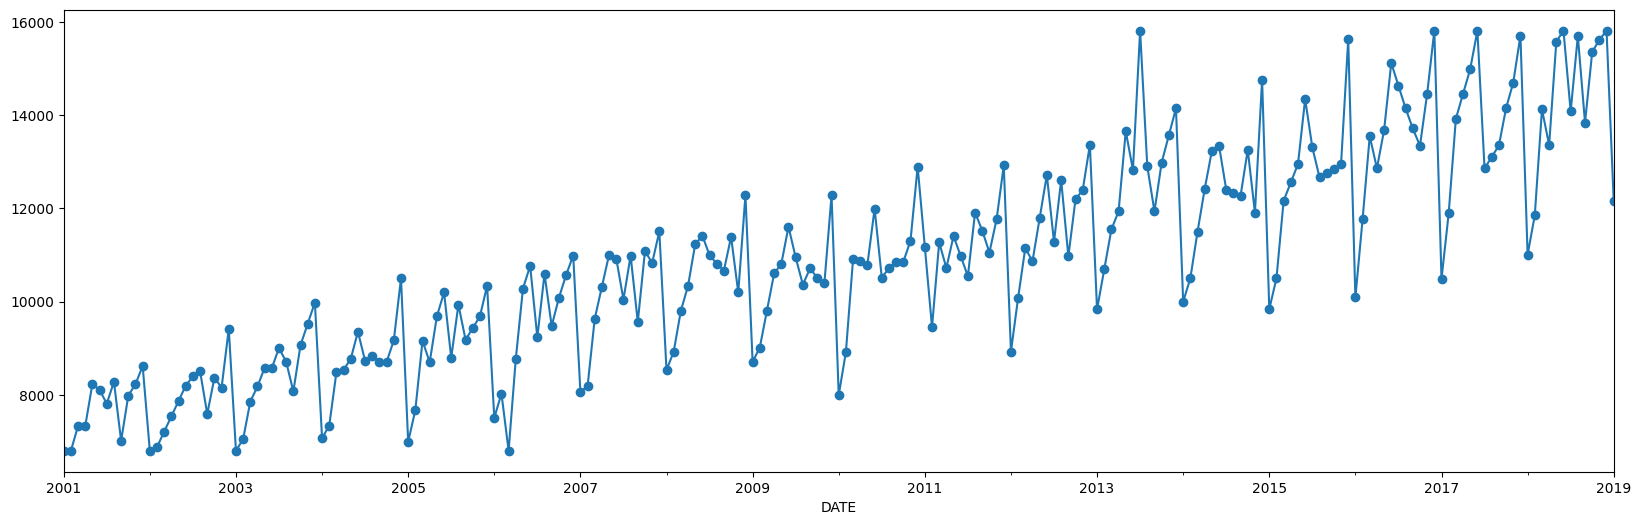

In [6]:

# linear interpolation
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

# plot
mobile_sales.Sales.plot(style='-o', figsize=(20,6))

**Train - test splitting of data**

In [17]:
train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x

,Sales
DATE,
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0


Also, let's create a function  to estimate the performance of different models

In [18]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

Recall that in the last lecture, we had not gotten the desired MAPE score using the **simple methods**.

Now that we've performed the required preprocessing on our time series, and even split it into train and test sets, lets look at another family of forecasting techniques, called **smoothing based models**.

---

# Smoothing Based Methods


Let's expand more on the Moving Averages model.
## 1. Moving average forecasting (Implementation)

We saw the illustration of concept of Moving averages using the `rolling()` function.

> **Q. How can we forecast future values using Moving Average concept?**

In order to make our forecast, we want to take the average of last 3 data values.

Let's look at the scratch implementation of the same.

![picture](https://drive.google.com/uc?export=view&id=1pFngGfjJUL-1wV2Gw2gQyfwT87Qa53tN)

Let's make a copy of the series in df, to avoid making changes in the original series.



In [19]:
import numpy as np

df = mobile_sales.copy()

> **Q. How do we obtain the dates for our future forecasts?**

Since we're working with a time series, naturally, we need to first create new data points with the future dates

As of now we have data till 2019-01-01, but we wish to forecast values for future.

The function **pd.date_range** is used to create the new dates for giving the forecasted values

We need to specify the following parameters in **pd.date_range**:-
- `start`: left bound for generating dates
- `periods`: Number of time steps in the range
- `freq`: frequency aliases, since we need month start frequency, our alias is `MS`. There are many more aliases.

Using the **pd.date_range**, we create a new dataframe that we can append to the existing one.

In [20]:
pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS'))

""
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01



**Note:**
- Notice that we got the first entry as Jan-2019, which already existed in our series.
- In order to take care of this, we need to explicitly mention that we want values from the second index of the result of `pd.date_range()`
- Hence we utilise slicing by mentioning `[1:]`

In [21]:
df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13,freq='MS')[1:]))

df.tail(20)

,Sales
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0
2018-12-01,15809.4
2019-01-01,12160.0
2019-02-01,NaN
2019-03-01,NaN


> **Q. How can we forecast future values using concept of Moving Averages?**

In order to forecast value for time t=k, we take average value of  the past n points, $x_{t-1}, x_{t-2}, x_{t-3}, ..., x_{t-n}$.

Calculate next point from MA of previous points. Then calculate the 2nd point using 1 previous forcasted point and remaining actual points and so on.

![picture](https://drive.google.com/uc?export=view&id=19cmb7-9VP-Vm7SxE9qEO1KUp6mn1PyZR)

<br>

> **Q. How do we code this?**

First, lets initialise a new variable `pred` to all the sales that are not NaN.

Now we run a loop. Since we wish to predict values for a year, the loop iterates 12 times.

Take the average of last 3 values on every iteration, and append it to the series.




In [22]:
df.Sales.tail(15)

2018-11-01    15615.0
2018-12-01    15809.4
2019-01-01    12160.0
2019-02-01        NaN
2019-03-01        NaN
2019-04-01        NaN
2019-05-01        NaN
2019-06-01        NaN
2019-07-01        NaN
2019-08-01        NaN
2019-09-01        NaN
2019-10-01        NaN
2019-11-01        NaN
2019-12-01        NaN
2020-01-01        NaN
Name: Sales, dtype: float64

In [23]:
pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

pred[-20:]

array([15809.4       , 14080.        , 15697.        , 13838.        ,
       15351.        , 15615.        , 15809.4       , 12160.        ,
       14528.13333333, 14165.84444444, 13617.99259259, 14103.99012346,
       13962.6090535 , 13894.86392318, 13987.15436671, 13948.20911446,
       13943.40913479, 13959.59087199, 13950.40304041, 13951.13434906])

So, we can see that we have forecasts here, based on average of last 3 points for all new points.

Let's round them.

In [24]:
pred = pred.round(1)
pred[-20:]

array([15809.4, 14080. , 15697. , 13838. , 15351. , 15615. , 15809.4,
       12160. , 14528.1, 14165.8, 13618. , 14104. , 13962.6, 13894.9,
       13987.2, 13948.2, 13943.4, 13959.6, 13950.4, 13951.1])

Now let's plot this.

<Axes: >

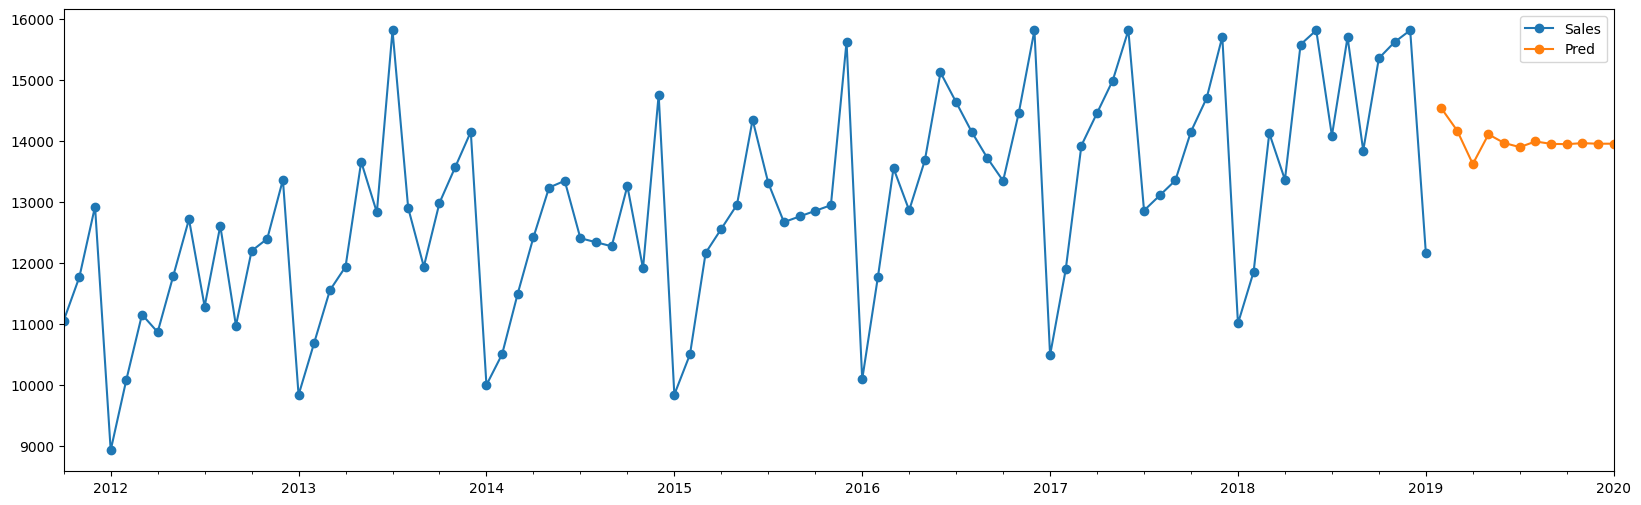

In [25]:
df['Pred'] = pred

df.loc[~df['Sales'].isna(), 'Pred'] = np.nan
df.tail(100).plot(style='-o')

> **Q. Does this look like a good forecast?**

These forecasted values are certainly better than forecasting the mean/median or any constant values. At least, the levels looks okay.

However, it can be clearly seen that the forecast is not able to predict the variations and it gives a flat line after few predictions.

<br>

Also, if you think about it, this technique, doesn't seem to using the past data.

What is the point of having data spanning over 18 years, if we're just looking at the last 3 entries to forecast a new value.

> **Q. What would be the performance of the Moving Averages model?**

While we're at it, let's check the performance of Moving Averages model also, by using train and test sets.

MAE : 1692.467
RMSE : 1875.03
MAPE: 0.115


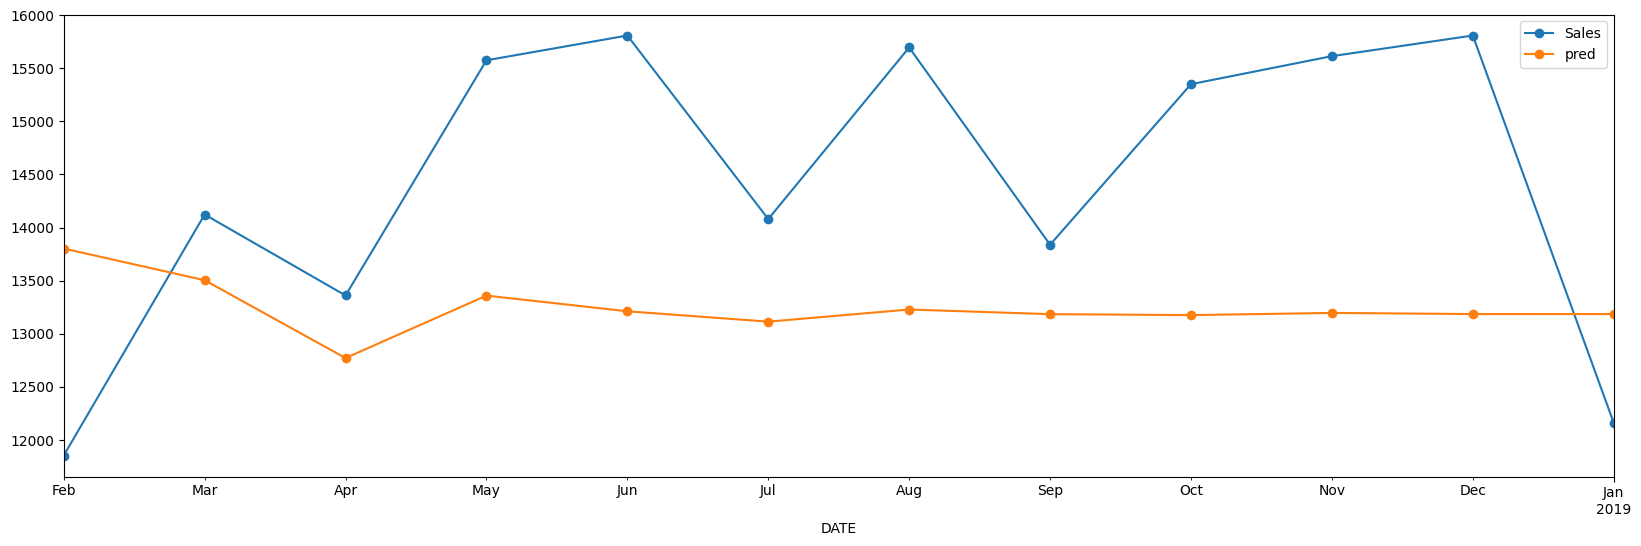

In [26]:
df = train_x.copy()

df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS')[1:]))

pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

test_x['pred'] = pred[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As per MAPE, we can say that our model has 11.5% error.

This is much better than the other models we saw. Lets look at more models.

## 2. Simple exponential smoothing

In order to avoid the shortcomings of Moving average forecasts, lets look at another forecasting technique, called **Simple exponential technique**.

> **Q. What is the idea behind Simple exponential technique?**

The key idea is that, we want to keep some memory of the entire time series, but also, we want to give more value to the recent most data.

Instead of ignoring the past values completely, let's assign them a small weight.

The major weight would still be assigned to the recent most entry.

This forms a decaying trend.

<br>

> **Q. Why do we need to consider the older data?**

 Let us assume a company was doing good for 10 years, and the sales went down for last 2 years because of **COVID-19** :
* Now if we predict sales, basing on the past few months, the forecast would be very low which is not an optimal prediction
* Hence it is required to consider the past series also to get a better forecast.


![picture](https://drive.google.com/uc?export=view&id=177iuo0YBDxvVoAYOh1pH4dSuTRjcN1V2)

<br>

#### Q. How can this idea be formulated mathematically?
Let's consider the weight we assign to the recent most value be $\alpha$.

$\alpha$ is called the **smoothing parameter**.

So, our forecast at time t becomes,

$ŷ_{t+h} = α*y_{t} + (1-α)*ŷ_{t}$

Here, $h$ is the **horizon**, it can take values such as $h=1, 2, 3, 4, ..$, it depicts the number of steps in future.

<br>

> **Q. We wanted to consider the entire time series, this formulation just has data of 2 points, why?**

This formulation is actually **recursive** in nature.

So, when we write $ŷ_{t-1}$, that gets broken down further as

$ŷ_{t+h} = α * y_{t} + (1-α)* [α* y_{t-1} + (1-α)*ŷ _{t-2}]$

This is further recursed in order to incorporate the entire time series.

<br>

> **Note:-**
- So, the concise form of writing the equation for SES is: $ŷ_{t+1} = αy_{t} + (1-α)ŷ_{t}$
- But if we were to open the expansion, the SES formulation is actually: $ŷ_{t+1} = αy_{t} + α(1-α)y_{t-1} + α(1-α)^2ŷ _{t-2} + ...$
- These are just different ways of writing the same equation; they're equivalent.



![picture](https://drive.google.com/uc?export=view&id=1UruTOKBSFF33-pVQH4_VYPiHHrC4oy8E)

<br>

> **Q. What does the plot of weights look like?**

We give more weightage to the most recent values, and this weightage keeps decreasing for earlier values.

As you can see from the formulation also, weights are exponentially decaying.

This is why. we call this method **Simple Exponential Smoothing**.


![picture](https://drive.google.com/uc?export=view&id=1ewCKPMW-_8CjtP2j5tgcdn_24C5aKaMH)

> **Q. How can we implement this concept in code?**

Let's look into the code for the same.

We have a built-in method for this technique `SimpleExpSmoothing()`, under **statsmodels** library.

While fitting this model, we need to specify the `smoothing_level` parameter, which is the same as $\alpha$ we've been looking at.
- The recommended starting point value for `smoothing_level` is $\frac{1}{2* seasonality}$
- For our case, this becomes $\frac{1}{2*12}$


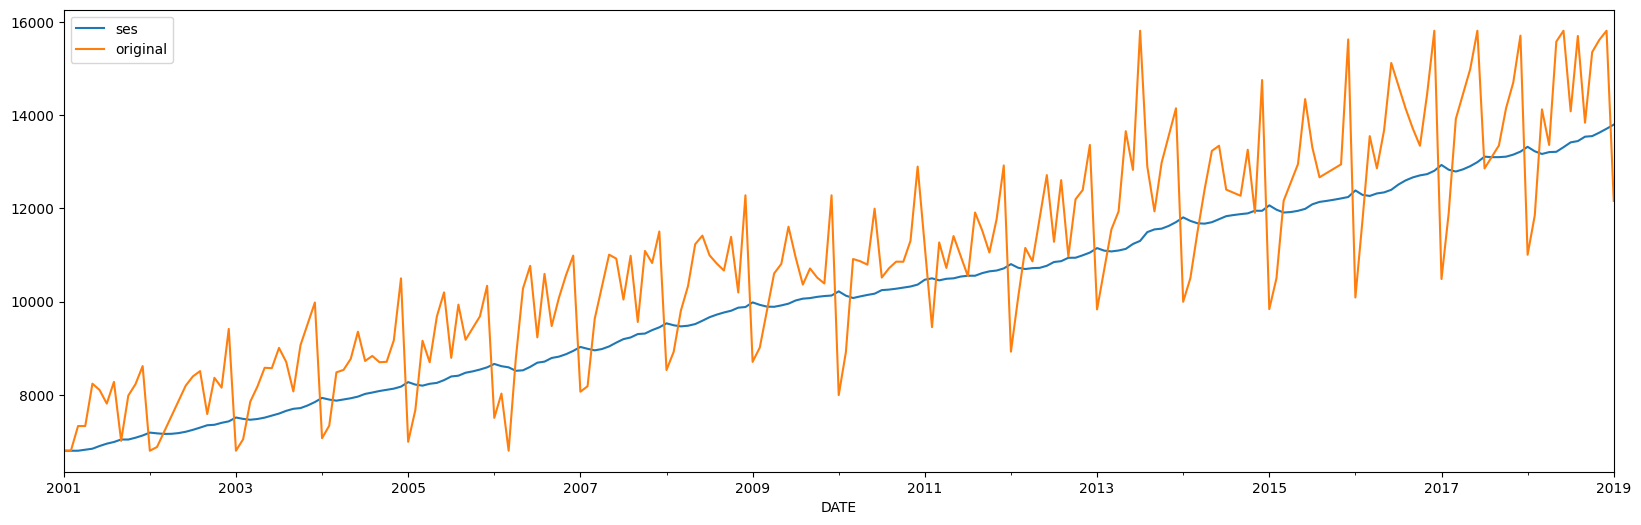

In [27]:
model = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12)).fittedvalues)

model.plot(label='ses')
mobile_sales.Sales.plot(label='original')
plt.legend()

From the graph, it looks like the Simple Exponential Smoothing, got the levels right.

> **Q. How is this plot different from Moving Averages plot?**

This looks similar.

But, Unlike moving averages, it **does not have the offset** in beginning and end, because this method is initialised properly.

They fix the previous values as well.

<br>

> **Q. How can we make future forecasts from this method?**

`SimpleExpSmoothing` in statsmodels also have a `forecast()` method.

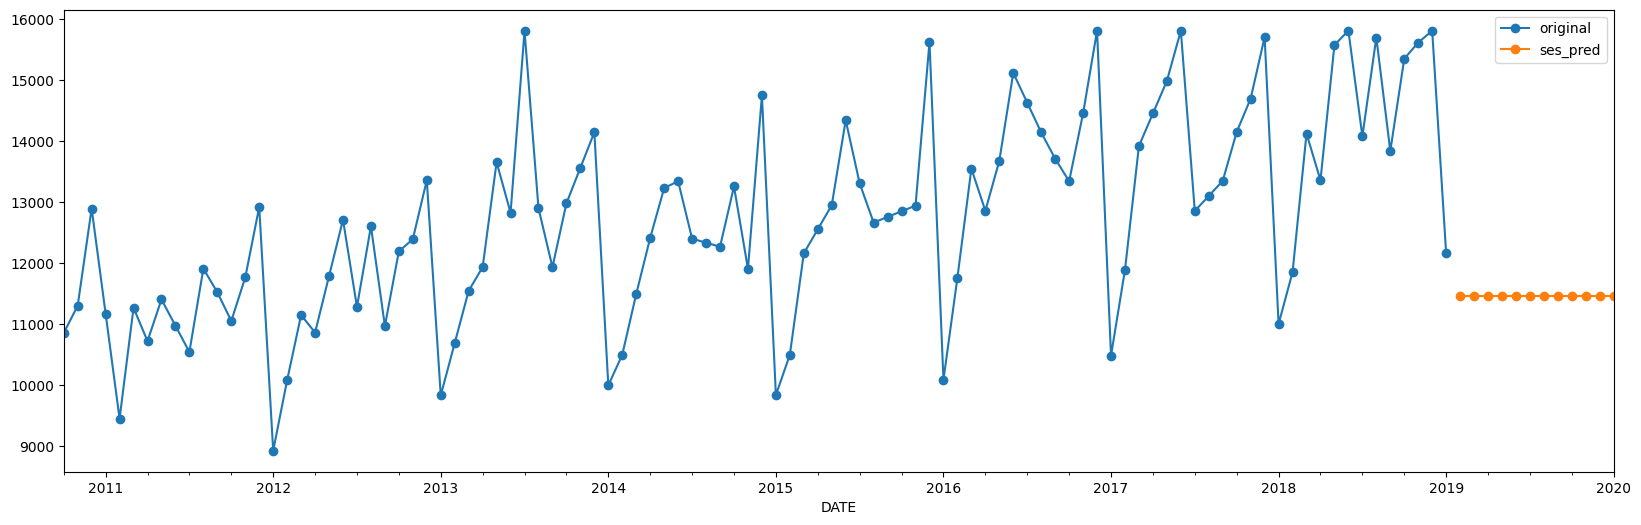

In [31]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12))
pred = model.forecast(steps = 12)

mobile_sales.Sales.tail(100).plot(label='original', style='-o')

pred.plot(label='ses_pred', style='-o')
plt.legend()

> **Q. Is this a good forecast?**

**No.**

In fact, it looks even worse. This is a complete straight line, surely, it can't be a good forecast.

This is because you dont have the previous *actual value* available for horizon > 1. So the current forecast is used for all next values.

But one advantage is that the **level of the forecasted values are right**.

So, we have the right levels, if we can predict the trend and seasonality right, we should get a good forecast.

<br>

Since it captures the correct level, for the forecast, this model would've worked well if:
- Consider our business case: We have data till January
- Suppose we are asked to forecast sales value for next month (February): $\hat{y}_{t+1}$
- Then we wait for Februaryto end, to observe the actual sales value: $y_{t+1}$
- Now, we forecast the value for March: $\hat{y}_{t+2}$
- This way, SES would be able to captue the trend also.

But this is not our business case, we've been asked to forecast values for the next 12 months.

![picture](https://drive.google.com/uc?export=view&id=16imbVgcjvQuwWlmkMjDL-SoHU4RimebP)


<br>


> **Q. What would be the performance of the Simple Exponential model?**

While we're at it, let's check the performance of Simple Exponential model also, by using train and test sets.

MAE : 1621.49
RMSE : 1830.741
MAPE: 0.109


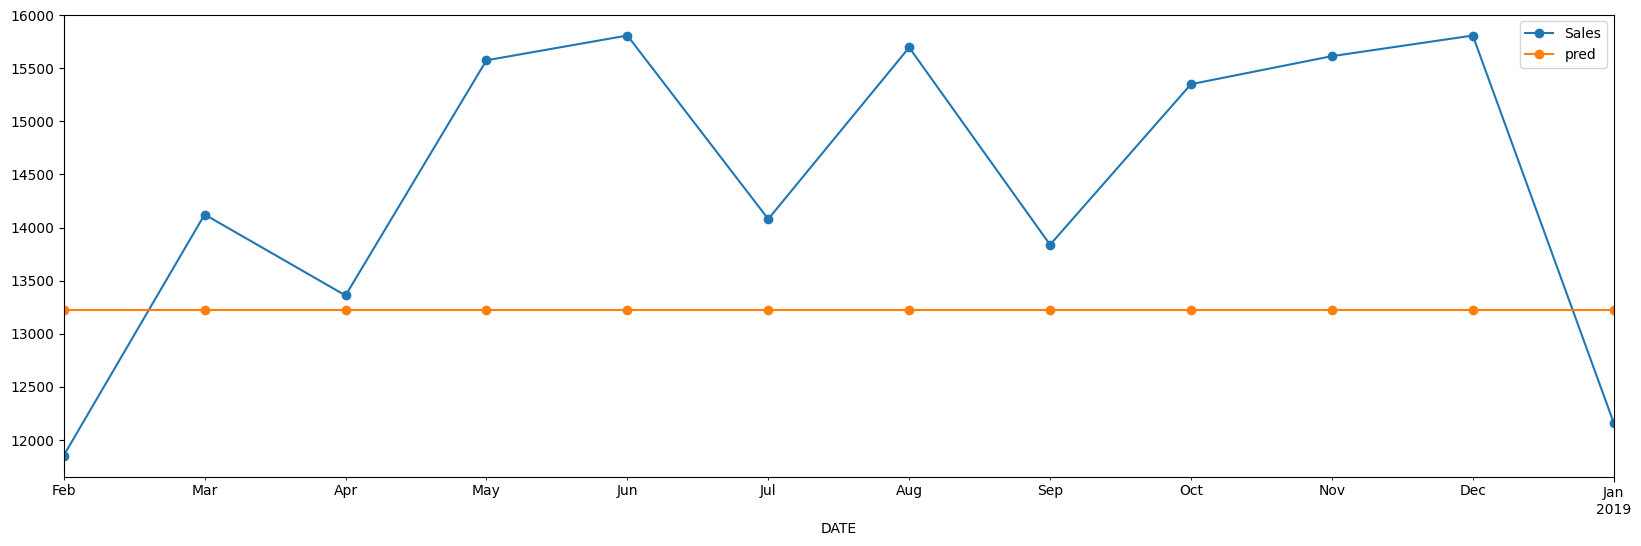

In [32]:
model = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As expected, the prediction is a straight line, but the erros is 10% which is less than the error of  moving average.

So this model is performing better.

<br>

The SES Model is missing both
- trend, and
- seasonality




---
---